# Import needed libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

2023-12-18 23:09:04.684803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 23:09:04.684874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 23:09:04.748187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 23:09:04.875884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 23:09:06.458804: W tensorflow/compiler/tf2

In [2]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


2023-12-18 23:09:10.554442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:10.794649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:10.794750: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:13.615314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:13.615446: I external/local_xla/xla/stream_executor

# Load Data

In [3]:
trainingset = 'train'
testset = 'test'

batch_size = 16
"""
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.3,\
    rotation_range=30,\
    width_shift_range=0.4,\
    height_shift_range=0.4,\
    horizontal_flip=True,\
    vertical_flip=False
    )
"""
train_datagen = ImageDataGenerator(
    rescale = 1. / 255)

#Generate batches of image data and their corresponding labels from a directory structure
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))


Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## Data distribution

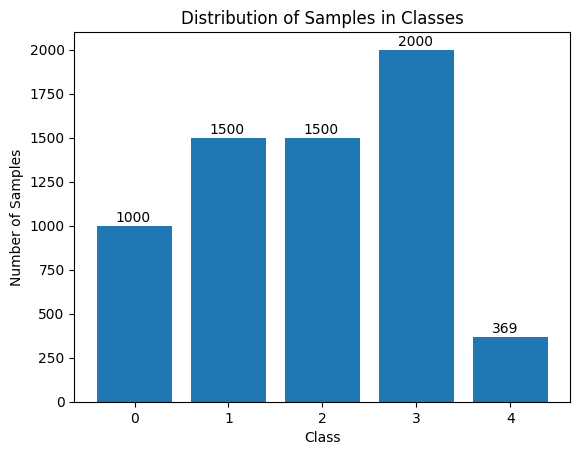

In [4]:
# Count the number of samples 
class_counts = {class_name: 0 for class_name in np.unique(train_generator.classes)}
for label in train_generator.classes:
    class_counts[label] += 1
    if sum(class_counts.values()) >= num_samples:
        break

# Plot the distribution
bars = plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples in Classes')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 25, yval,)
plt.show()


# I Model

In [5]:

def Net(input_shape, num_classes, regl2 = 0.01, lr=0.001):

    model = Sequential()

    # C1 Convolutional Layer
    model.add(Conv2D(filters=6, input_shape=input_shape, kernel_size=(5,5),\
                     strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation before passing it to the next layer
    model.add(BatchNormalization())

    # C2 Convolutional Layer
    model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Flatten
    model.add(Flatten())

    flatten_shape = (input_shape[0]*input_shape[1]*input_shape[2],)

    # D1 Dense Layer
    model.add(Dense(120, input_shape=flatten_shape, kernel_regularizer=regularizers.l2(regl2)))
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.4))
    # Batch Normalisation
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # Compile

    adam = optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

# create the model
model = Net(input_shape,num_classes)
model.summary()

# history of results (set to None when initializing a new mdoel)
history = None


2023-12-18 23:09:14.510711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:14.510856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:14.510902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:14.511110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-18 23:09:14.511178: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 6)         456       
                                                                 
 activation (Activation)     (None, 92, 92, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 6)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 46, 46, 6)         24        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 42, 42, 16)        0

## Train

In [6]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [7]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

epochs = 20  # sets number of epochs

try:
    h = model.fit(train_generator, epochs=epochs, verbose=1,\
                    steps_per_epoch=steps_per_epoch,\
                    #class_weight=class_weight_dict,\
                    validation_data=test_generator,\
                    validation_steps=val_steps
                    ) # validation set????
except KeyboardInterrupt:
    pass

# append current history

if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])

Epoch 1/20


2023-12-18 23:09:18.349254: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-18 23:09:21.390107: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 23:09:22.759845: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 23:09:23.918356: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff9f402aa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 23:09:23.918445: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
2023-12-18 23:09:23.996212: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702937364.176204    2686 device_compiler.h:1

398/398 [==============================] - 22s 26ms/step - loss: 2.1760 - accuracy: 0.5029 - val_loss: 1.7881 - val_accuracy: 0.5227
Epoch 2/20
398/398 [==============================] - 8s 20ms/step - loss: 1.6809 - accuracy: 0.5457 - val_loss: 1.4803 - val_accuracy: 0.6701
Epoch 3/20
398/398 [==============================] - 8s 21ms/step - loss: 1.8728 - accuracy: 0.5459 - val_loss: 1.7996 - val_accuracy: 0.5344
Epoch 4/20
398/398 [==============================] - 9s 21ms/step - loss: 1.5692 - accuracy: 0.5582 - val_loss: 1.3011 - val_accuracy: 0.6493
Epoch 5/20
398/398 [==============================] - 9s 22ms/step - loss: 1.6322 - accuracy: 0.5682 - val_loss: 1.4812 - val_accuracy: 0.6428
Epoch 6/20
398/398 [==============================] - 9s 22ms/step - loss: 1.5773 - accuracy: 0.5657 - val_loss: 1.3286 - val_accuracy: 0.6715
Epoch 7/20
398/398 [==============================] - 9s 22ms/step - loss: 1.5283 - accuracy: 0.5652 - val_loss: 1.4115 - val_accuracy: 0.5962
Epoch 8/2

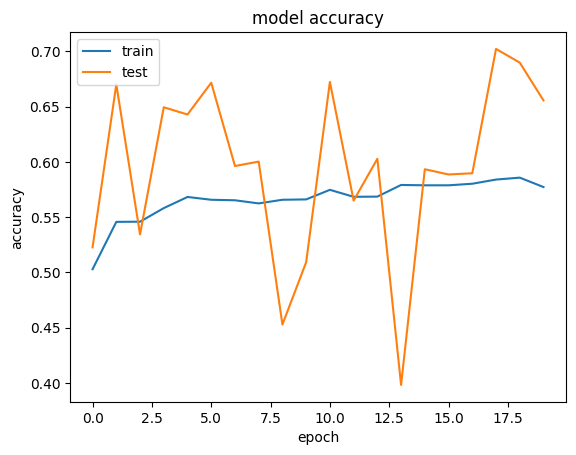

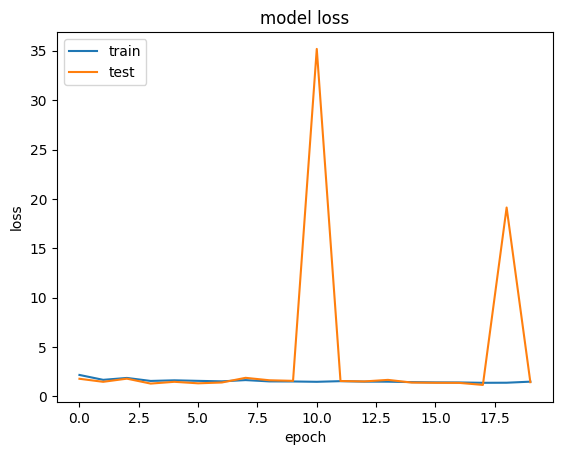

In [11]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') #label of line
plt.show()

## Save model

In [9]:
models_dir = 'models'
modelname = 'model1_%d_epochs' %len(history['loss'])

def savemodel(problem,model,history):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)
    filename = os.path.join(models_dir, '%s_history.pkl' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history, f)
    print("History saved successfully on file %s\n" %filename)

# Save model and history
savemodel(modelname,model,model.history)


/home/gioia/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model saved successfully on file models/model1_20_epochs.h5

History saved successfully on file models/model1_20_epochs_history.pkl



## Evaluate

In [10]:
test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)
val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate(test_generator,verbose=1,steps=val_steps)
print(model.predict(test_generator,verbose=1,steps=val_steps).argmax(axis=1))
print('Test loss: %f' %loss)
print('Test accuracy: %f' %acc)



Found 2749 images belonging to 5 classes.
172/172 [==============================] - 2s 10ms/step
[3 3 3 ... 2 2 2]
Test loss: 1.443784
Test accuracy: 0.655511


## Find the optimal number of epoches

# Model with feature extraction

## Feature Extraction

## Classifier